# Image classification task
- Image classification on OpenML Task (362127), tiniest ImageNet dataset.

In [ ]:
import torch.nn
import torch.optim

import openml_pytorch.config
import openml
import logging
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

############################################################################
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

from openml_pytorch.trainer import convert_to_rgb

## Define the Model

In [ ]:
model = torchvision.models.efficientnet_b0(num_classes=200)

## Configure the Data Module

In [ ]:
transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(
            convert_to_rgb
        ),  # Convert PIL Image to RGB if it's not already.
        Resize(
            (64, 64)
        ),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="Class_encoded",
    batch_size = 64,
    transform=transform
)

## Configure the Trainer Module

In [ ]:
trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
    callbacks=[],
)
openml_pytorch.config.trainer = trainer

## Download the task

In [ ]:
# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362127)

## Run the model on the task

In [ ]:
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View loss

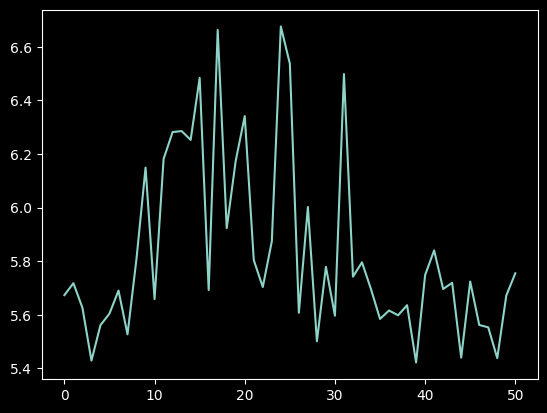

In [ ]:
trainer.runner.cbs[1].plot_loss()

## View learning rate

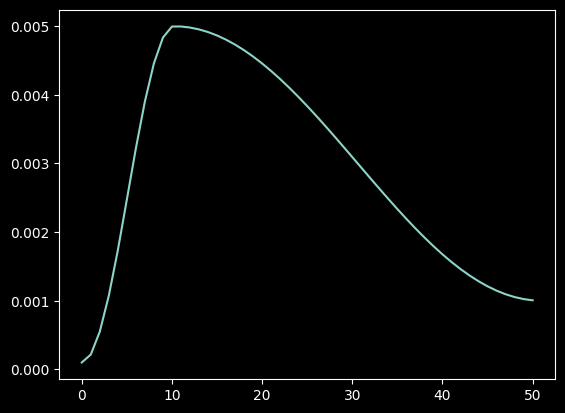

In [ ]:
trainer.runner.cbs[1].plot_lr()

## View the classes in the model

In [ ]:
trainer.learn.model_classes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Publish the run to OpenML

In [ ]:
run.publish()